# Markov Blanket Feature Selection on a Medical Dataset

In this notebook, we demonstrate how to perform feature selection using the concept of a Markov Blanket. We illustrate the process on the Breast Cancer Wisconsin (Diagnostic) dataset. The steps include:

1. **Loading and Preprocessing the Data:** Converting to a DataFrame and discretizing continuous features.
2. **Learning a Bayesian Network Structure:** Using Hill Climbing Search with the BIC score.
3. **Extracting the Markov Blanket:** Obtaining the minimal set of features that directly influence (or shield) the target variable.

This notebook can serve as a template for applying the Markov Blanket method to other real-world medical (or general) datasets.

In [4]:
!pip install pgmpy

## Step 1: Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import KBinsDiscretizer

In [3]:
# We use pgmpy for structure learning and Markov Blanket extraction.
from pgmpy.estimators import HillClimbSearch, BIC
import networkx as nx

## Step 2: Load and Prepare the Dataset

Here we load the Breast Cancer dataset from scikit‑learn and convert it to a pandas DataFrame. The target variable is added as a column named `'target'`.

In [5]:
# Load the Breast Cancer dataset from scikit-learn
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [6]:
# Display the first few rows
print("Dataset preview:")
display(df.head())

Dataset preview:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Step 3: Exploratory Data Analysis (EDA)

Before applying any transformations, we explore the dataset. We examine the basic information and summary statistics, visualize the distribution of the target variable, and plot histograms of a few features.

### Dataset Information
- **Shape:** Number of rows and columns.
- **Summary Statistics:** Mean, standard deviation, and quartiles.

### Visualizations
- **Target Distribution:** A bar chart showing the frequency of each class.
- **Feature Histograms:** Histograms for a subset of features to inspect their distribution.

In [21]:
# Basic dataset information
print("Dataset shape:", df.shape)
print("\nDataset information:")
df.info()

print("\nSummary statistics:")
display(df.describe())

Dataset shape: (569, 31)

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


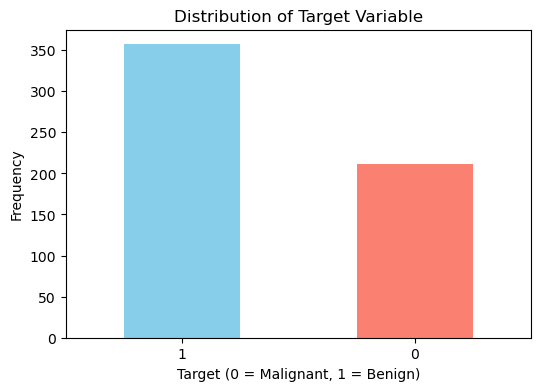

In [22]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Distribution of Target Variable")
plt.xlabel("Target (0 = Malignant, 1 = Benign)")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

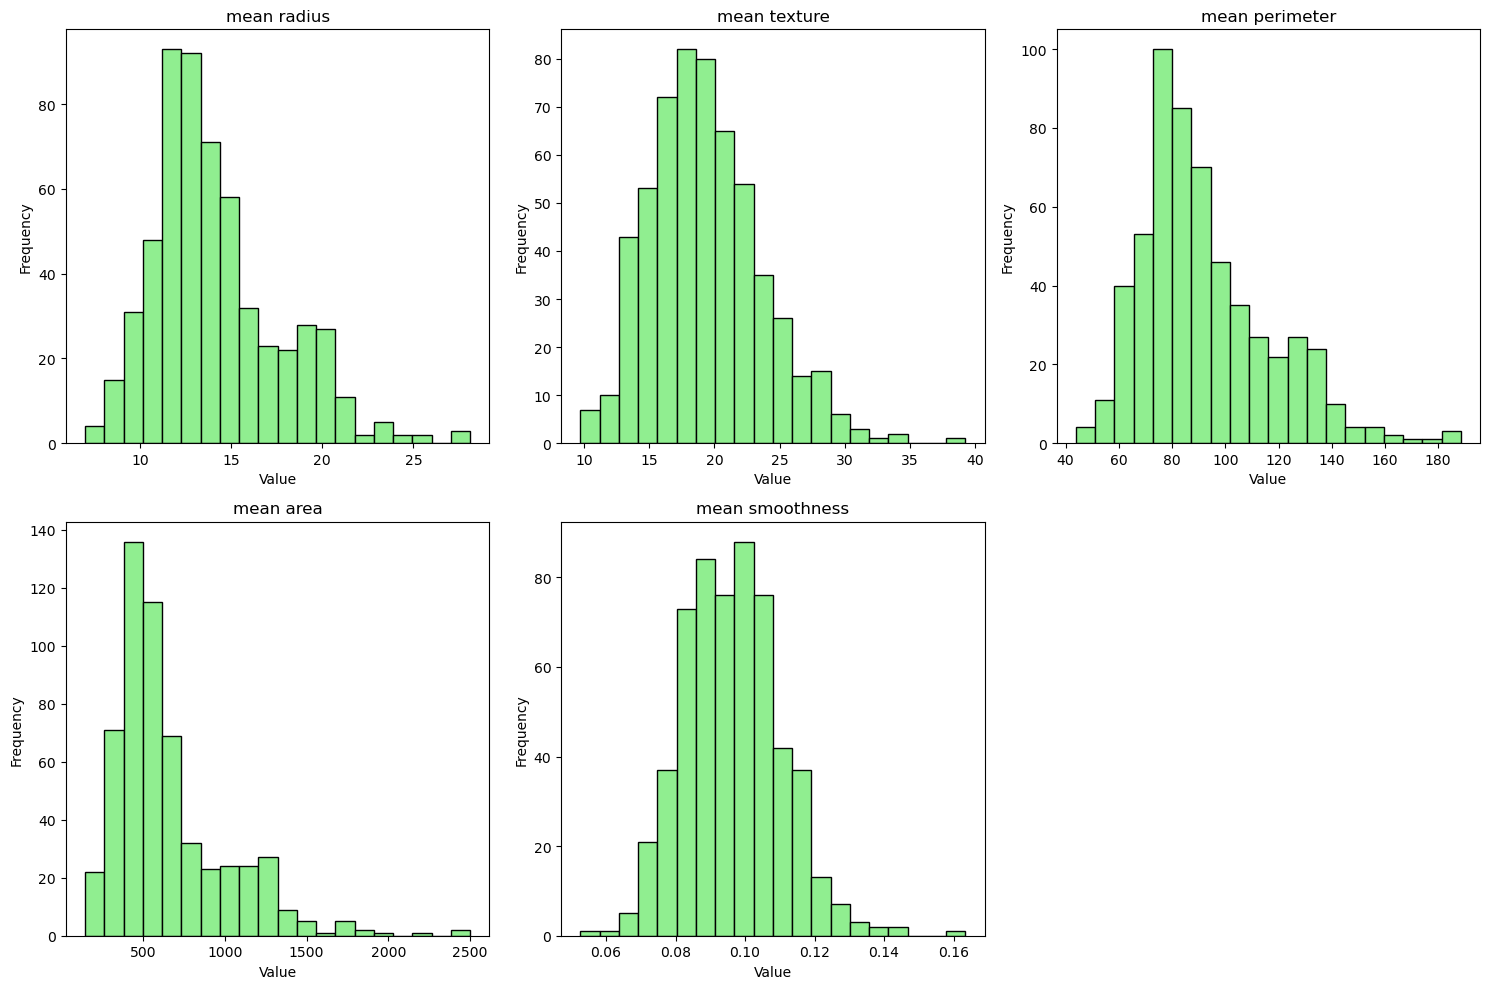

In [23]:
# Plot histograms for a subset of the features
features_to_plot = df.columns[:5]  # Plot first 5 features for illustration

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[feature], bins=20, color='lightgreen', edgecolor='black')
    plt.title(f"{feature}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Step 3.1: Discretize Continuous Features
 
Many algorithms in Bayesian network structure learning work best with discrete data. We discretize all the feature columns using the KBinsDiscretizer. In this example, we use 5 bins and the 'uniform' strategy. The target variable is already discrete (0 or 1) and is not transformed.

In [7]:
# List features to discretize (all columns except 'target')
features = df.columns.drop('target')

In [8]:
# Initialize the discretizer
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

In [9]:
# Fit and transform the features
df_discrete = df.copy()
df_discrete[features] = discretizer.fit_transform(df_discrete[features])

In [10]:
# Preview the discretized data
print("Discretized features preview:")
display(df_discrete.head())

Discretized features preview:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,2.0,0.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,...,0.0,3.0,2.0,3.0,3.0,2.0,4.0,2.0,2.0,0
1,3.0,1.0,3.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,2.0,2.0,1.0,0.0,0.0,3.0,1.0,1.0,0
2,3.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,1.0,...,1.0,2.0,1.0,2.0,1.0,1.0,4.0,2.0,1.0,0
3,1.0,1.0,1.0,0.0,4.0,4.0,2.0,2.0,3.0,4.0,...,1.0,1.0,0.0,4.0,4.0,2.0,4.0,4.0,3.0,0
4,3.0,0.0,3.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,...,0.0,2.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0


## Step 3.2: Learn the Bayesian Network Structure Using HC with BIC
 
We now apply the Hill Climbing Search algorithm to learn a Bayesian network structure from the (discretized) data. The BIC scoring function is used to guide the search. Once the structure is learned, we have a directed acyclic graph (DAG) representing our variable dependencies.

In [12]:
# Initialize the score method and the Hill Climbing Search
score = BIC(df_discrete)
hc = HillClimbSearch(df_discrete)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'mean radius': 'N', 'mean texture': 'N', 'mean perimeter': 'N', 'mean area': 'N', 'mean smoothness': 'N', 'mean compactness': 'N', 'mean concavity': 'N', 'mean concave points': 'N', 'mean symmetry': 'N', 'mean fractal dimension': 'N', 'radius error': 'N', 'texture error': 'N', 'perimeter error': 'N', 'area error': 'N', 'smoothness error': 'N', 'compactness error': 'N', 'concavity error': 'N', 'concave points error': 'N', 'symmetry error': 'N', 'fractal dimension error': 'N', 'worst radius': 'N', 'worst texture': 'N', 'worst perimeter': 'N', 'worst area': 'N', 'worst smoothness': 'N', 'worst compactness': 'N', 'worst concavity': 'N', 'worst concave points': 'N', 'worst symmetry': 'N', 'worst fractal dimension': 'N', 'target': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'mean radius': 'N', 'mean texture': 'N', 'mean p

In [13]:
# Estimate the best model (this may take a moment)
best_model = hc.estimate(scoring_method=score)

print("Learned Bayesian Network edges:")
print(best_model.edges())

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'mean radius': 'N', 'mean texture': 'N', 'mean perimeter': 'N', 'mean area': 'N', 'mean smoothness': 'N', 'mean compactness': 'N', 'mean concavity': 'N', 'mean concave points': 'N', 'mean symmetry': 'N', 'mean fractal dimension': 'N', 'radius error': 'N', 'texture error': 'N', 'perimeter error': 'N', 'area error': 'N', 'smoothness error': 'N', 'compactness error': 'N', 'concavity error': 'N', 'concave points error': 'N', 'symmetry error': 'N', 'fractal dimension error': 'N', 'worst radius': 'N', 'worst texture': 'N', 'worst perimeter': 'N', 'worst area': 'N', 'worst smoothness': 'N', 'worst compactness': 'N', 'worst concavity': 'N', 'worst concave points': 'N', 'worst symmetry': 'N', 'worst fractal dimension': 'N', 'target': 'N'}
  0%|          | 27/1000000 [00:03<33:50:56,  8.21it/s]

Learned Bayesian Network edges:
[('mean radius', 'mean perimeter'), ('mean perimeter', 'mean area'), ('mean smoothness', 'worst smoothness'), ('mean compactness', 'mean smoothness'), ('mean compactness', 'mean symmetry'), ('mean concavity', 'worst concavity'), ('mean concavity', 'mean compactness'), ('mean concavity', 'concave points error'), ('mean concave points', 'mean concavity'), ('mean symmetry', 'worst symmetry'), ('radius error', 'perimeter error'), ('perimeter error', 'area error'), ('compactness error', 'concavity error'), ('compactness error', 'fractal dimension error'), ('concave points error', 'compactness error'), ('worst radius', 'mean radius'), ('worst radius', 'worst area'), ('worst texture', 'mean texture'), ('worst perimeter', 'worst radius'), ('worst perimeter', 'target'), ('worst perimeter', 'radius error'), ('worst compactness', 'worst fractal dimension'), ('worst concavity', 'worst compactness'), ('worst concave points', 'mean concave points'), ('worst fractal di

## Step 3.3: Extract the Markov Blanket for the Target Variable

Using the learned Bayesian network, we extract the Markov Blanket for the target variable. In Bayesian networks, the Markov Blanket of a node includes its parents, its children, and the other parents of its children. These are the minimal features that render the target conditionally independent of the remaining nodes.

In [14]:
# Extract the Markov Blanket of the 'target' variable
markov_blanket = best_model.get_markov_blanket('target')
print("\nMarkov Blanket for 'target':")
print(markov_blanket)


Markov Blanket for 'target':
['worst perimeter', 'worst texture', 'worst concave points']


## Step 3.4: Visualize the Learned Bayesian Network

For additional insight, we can visualize the Bayesian network structure. The Markov Blanket nodes are highlighted in the visualization.

In [15]:
# Create a graph from the learned model
G = nx.DiGraph()
G.add_edges_from(best_model.edges())

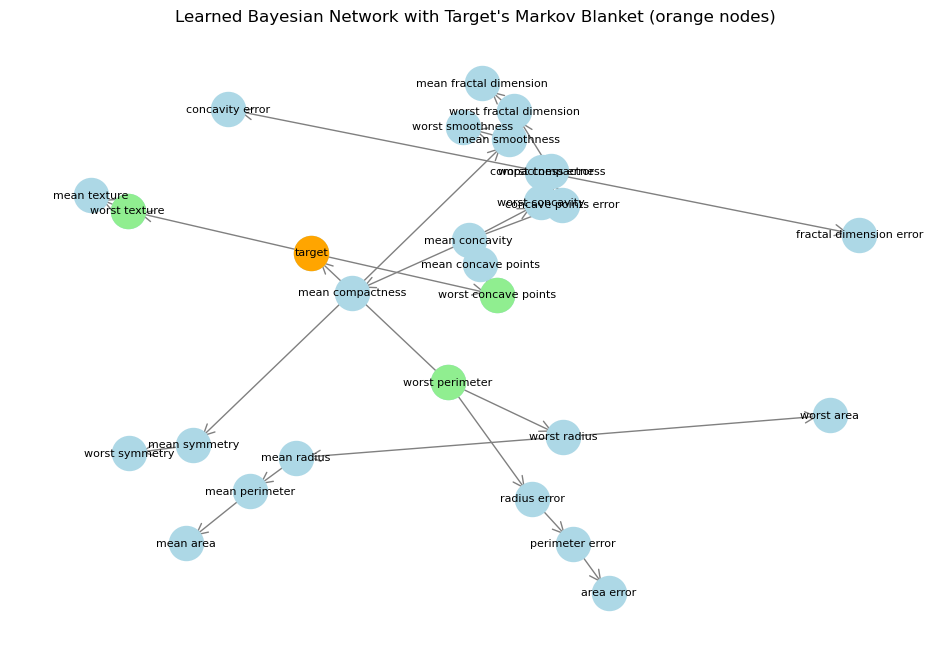

In [62]:
# Get positions for the nodes in the graph layout
pos = nx.spring_layout(G, seed=42)  # seed for reproducibility

plt.figure(figsize=(12, 8))
# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=600)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

# Highlight the Markov Blanket nodes for the target
mb_nodes = markov_blanket
nx.draw_networkx_nodes(G, pos, nodelist=mb_nodes, node_color='lightgreen', node_size=600)
nx.draw_networkx_nodes(G, pos, nodelist=['target'], node_color='orange', node_size=600)

plt.title("Learned Bayesian Network with Target's Markov Blanket (orange nodes)")
plt.axis("off")
plt.show()

## Step 4.1: Causal Discovery with the HC Algorithm

In this step, we use the HC algorithm on the original mixed‑type data (without discretization). 

In [37]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.4/150.0 MB 11.2 MB/s eta 0:00:14
   - -------------------------------------- 5.8/150.0 MB 13.6 MB/s eta 0:00:11
   --- ------------------------------------ 13.1/150.0 MB 21.1 MB/s eta 0:00:07
   ----- ---------------------------------- 21.8/150.0 MB 26.5 MB/s eta 0:00:05
   -------- ------------------------------- 31.2/150.0 MB 30.0 MB/s eta 0:00:04
   ----------- ---------------------------- 41.9/150.0 MB 33.8 MB/s eta 0:00:04
   -------------- ------------------------- 54.3/150.0 MB 37.2 MB/s eta 0:00:03
   ----------------- ---------------------- 65.5/150.0 MB 39.4 MB/s eta 0:00:03
   -------------------- ------------------- 77.6/150.0 MB 41.2 MB/s eta 0:00:02
   ----------------------- ---------------- 88.9/150.0 MB 42.3 MB/s eta 0:00:02
   -------------------------- ------------ 100.1/150.0 MB 43.5 MB/s eta 0:00:02
   ----------------------------- --------- 111.7/15

In [52]:
# Run the HC algorithm on the original data
hc = HillClimbSearch(df)
hcg = hc.estimate(scoring_method=score)

print("Learned Bayesian Network edges:")
print(hcg.edges())

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'mean radius': 'N', 'mean texture': 'N', 'mean perimeter': 'N', 'mean area': 'N', 'mean smoothness': 'N', 'mean compactness': 'N', 'mean concavity': 'N', 'mean concave points': 'N', 'mean symmetry': 'N', 'mean fractal dimension': 'N', 'radius error': 'N', 'texture error': 'N', 'perimeter error': 'N', 'area error': 'N', 'smoothness error': 'N', 'compactness error': 'N', 'concavity error': 'N', 'concave points error': 'N', 'symmetry error': 'N', 'fractal dimension error': 'N', 'worst radius': 'N', 'worst texture': 'N', 'worst perimeter': 'N', 'worst area': 'N', 'worst smoothness': 'N', 'worst compactness': 'N', 'worst concavity': 'N', 'worst concave points': 'N', 'worst symmetry': 'N', 'worst fractal dimension': 'N', 'target': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'mean radius': 'N', 'mean texture': 'N', 'mean p

Learned Bayesian Network edges:
[('mean radius', 'mean perimeter'), ('mean perimeter', 'mean area'), ('mean smoothness', 'worst smoothness'), ('mean compactness', 'mean smoothness'), ('mean compactness', 'mean symmetry'), ('mean concavity', 'worst concavity'), ('mean concavity', 'mean compactness'), ('mean concavity', 'concave points error'), ('mean concave points', 'mean concavity'), ('mean symmetry', 'worst symmetry'), ('radius error', 'perimeter error'), ('perimeter error', 'area error'), ('compactness error', 'concavity error'), ('compactness error', 'fractal dimension error'), ('concave points error', 'compactness error'), ('worst radius', 'mean radius'), ('worst radius', 'worst area'), ('worst texture', 'mean texture'), ('worst perimeter', 'worst radius'), ('worst perimeter', 'target'), ('worst perimeter', 'radius error'), ('worst compactness', 'worst fractal dimension'), ('worst concavity', 'worst compactness'), ('worst concave points', 'mean concave points'), ('worst fractal di

## Step 4.2: Extract the Markov Blanket for the Target Variable
 
From the learned Bayesian model, we extract the Markov Blanket for the target variable (`'target'`). The Markov Blanket consists of the node’s parents, its children, and the other parents of its children, which together render the target conditionally independent of the remaining nodes.


In [55]:
# Extract the Markov Blanket for 'target'
markov_blanket = hcg.get_markov_blanket('target')
print("\nMarkov Blanket for 'target':")
print(markov_blanket)


Markov Blanket for 'target':
['worst perimeter', 'worst texture', 'worst concave points']


## Step 4.3: Visualize the Learned Causal Graph
 
We visualize the learned (causal) Bayesian network. In the graph below, the nodes belonging to the Markov Blanket of the target variable are highlighted in orange.


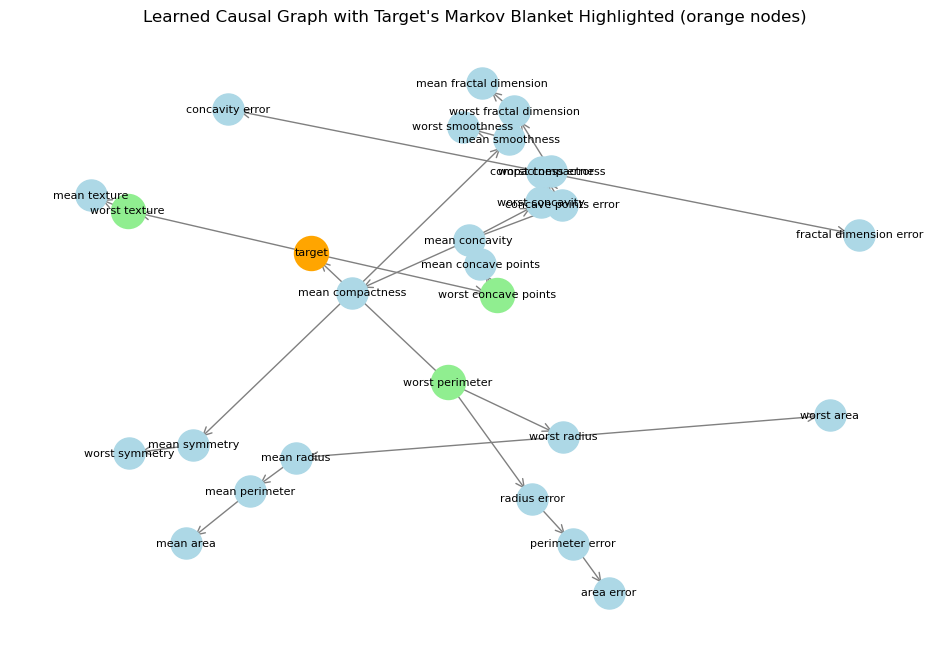

In [61]:
# Build a directed graph from the model's edges for visualization
G = nx.DiGraph()
G.add_edges_from(hcg.edges())

# Use a spring layout for visualization
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 8))
# Draw all nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

# Highlight Markov Blanket nodes
nx.draw_networkx_nodes(G, pos, nodelist=markov_blanket, node_color='lightgreen', node_size=600)
nx.draw_networkx_nodes(G, pos, nodelist=['target'], node_color='orange', node_size=600)

plt.title("Learned Causal Graph with Target's Markov Blanket Highlighted (orange nodes)")
plt.axis("off")
plt.show()

## Conclusion

In this notebook, we demonstrated how to use a Bayesian network structure learning approach to identify the Markov Blanket of the target variable in a medical dataset. The extracted Markov Blanket provides a subset of features that are most relevant to the target variable, which can be especially useful for reducing dimensionality and improving interpretability in downstream tasks.

You can extend this approach to other datasets or experiment with different discretization strategies and structure learning algorithms for further insights.